In [100]:
import pandas as pd
import numpy as np
import requests
import os
import time
import matplotlib.pyplot as plt

In [201]:
coin_name = 'ETH'
unit = 'usd'

filename="tiingo_%s.csv"%coin_name
coin = pd.read_csv(filename)
coin.Date = pd.to_datetime(coin.Date)

In [202]:
future = pd.read_pickle('../../data/btc future and reference rate/concated_cleaned_bbt_future.pkl')

merged = future.merge(coin, on = 'Date', how='inner')
merged = merged.drop_duplicates()

merged.PX_LAST = merged.PX_LAST.astype('float')
merged.loc[:, '%s Price'%coin_name] = merged.loc[:, '%s Price'%coin_name].astype('float')

merged.loc[:, 'log return future'] = np.log(merged.PX_LAST/merged.PX_LAST.shift(-1))
merged.loc[:, 'log return %s'%coin_name] = np.log(merged.loc[:, '%s Price'%coin_name]/merged.loc[:,'%s Price'%coin_name].shift(-1))

merged = merged.iloc[:-1,:]

rs = merged.loc[:, 'log return %s'%coin_name]
rf = merged.loc[:, 'log return future']

from statsmodels.distributions.empirical_distribution import ECDF

ecdf_rs = ECDF(rs)
ecdf_rf = ECDF(rf)
ecdf_rh = ECDF(rs-rf)

m = min([np.min(rs), np.min(rf)])
M = max([np.max(rs), np.max(rf)])

In [203]:
merged = merged.iloc[:,[0,1,2,4,5,6]]

In [204]:
merged.to_csv('../../data/cleaned_data/BBT_future_Tiingo_%s.csv'%coin_name)

Text(0, 0.5, 'Future(CME BTC)')

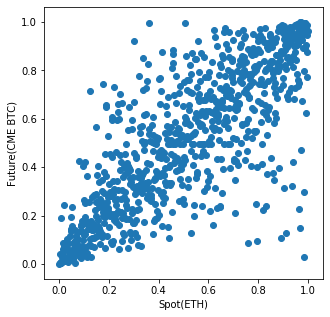

In [205]:
plt.figure(figsize=(5,5))
plt.scatter(ecdf_rs(rs), ecdf_rf(rf))
plt.xlabel('Spot(%s)'%coin_name)
plt.ylabel('Future(CME BTC)')

In [206]:
test = merged.iloc[:300, :]
train = merged.iloc[300:600, :]

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [207]:
import os, sys
sys.path.append('../../src/')
from KDEs import *
from copulae1 import *
from toolbox import *
import os

In [208]:
rs = train.loc[:, 'log return %s'%coin_name]
rf = train.loc[:, 'log return future']

kde_btc_future = KDE(rf, "Gaussian")
kde_eth = KDE(rs, "Gaussian")

u = ECDF(rs)(rs)
v = ECDF(rf)(rf)

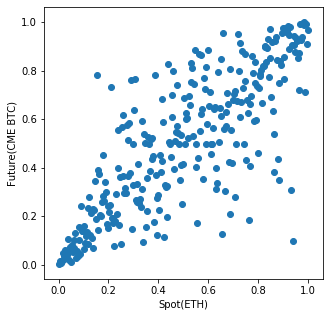

In [209]:
plt.figure(figsize=(5,5))
plt.xlabel('Spot(%s)'%coin_name)
plt.ylabel('Future(CME BTC)')
plt.scatter(u,v)

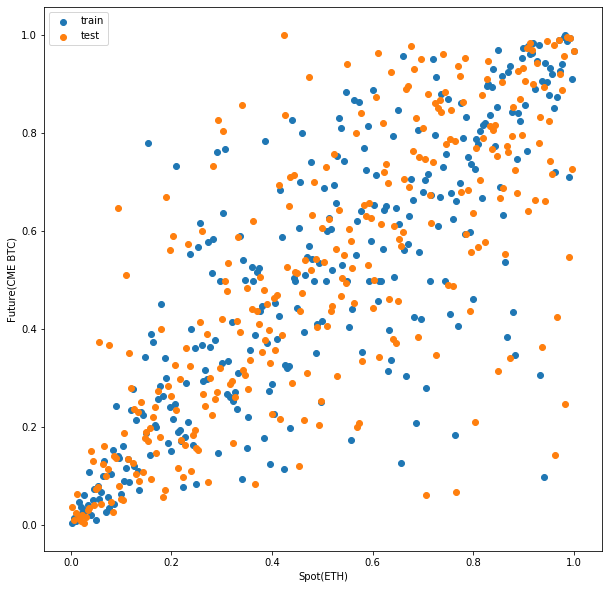

In [210]:
rs_test = test.loc[:, 'log return %s'%coin_name]
rf_test = test.loc[:, 'log return future']

u_test = ECDF(rs_test)(rs_test)
v_test = ECDF(rf_test)(rf_test)

plt.figure(figsize=(10,10))
plt.xlabel('Spot(%s)'%coin_name)
plt.ylabel('Future(CME BTC)')
plt.scatter(u,v, label='train')
plt.scatter(u_test,v_test, label='test')
plt.legend()

In [211]:
C1 = Gaussian({'rho':0.9}, kde_eth, kde_btc_future)
C1.canonical_calibrate(u,v)

C2 = t_Copula({'rho':0.9, 'nu':4}, kde_eth, kde_btc_future, 2)
C2.canonical_calibrate(u,v)

C3 = Gumbel({'theta':1}, kde_eth, kde_btc_future)
C3.canonical_calibrate(u,v)

../../src/copulae1.py:116: RuntimeWarning: invalid value encountered in true_divide
  return np.nanmean(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -0.570636
         Iterations: 32
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: -0.621242
         Iterations: 78
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.509865
         Iterations: 38
         Function evaluations: 81


2.404379081726077

In [212]:
print('\n',
      C1.paras, '\n', 
      C2.paras, '\n',
      C3.paras)


 {'rho': 0.831573189496994} 
 {'rho': 0.8338697381753446, 'nu': 3.011807815434017} 
 {'theta': 2.404379081726077}


In [213]:
C1.l_fn(C1.paras['rho'], u,v)

0.5758862291995255

In [214]:
C2.l_fn(C2.paras['rho'],C2.paras['nu'], u,v)

0.6147772675385291

In [215]:
k_arr = [10]
q_arr_ES = [0.01,0.05]
q_arr_VaR = [0.01,0.05]

h1_arr = optimize_h(C1, k_arr, q_arr_ES, q_arr_VaR)

Optimization terminated successfully.
         Current function value: 0.001150
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.056004
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.139604
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.087083
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.105482
         Iterations: 11
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.055387
         Iterations: 13
         Function evaluations: 27


In [216]:
h2_arr = optimize_h(C2, k_arr, q_arr_ES, q_arr_VaR)

Optimization terminated successfully.
         Current function value: 0.001359
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.060150
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.163209
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.095560
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.115334
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.059028
         Iterations: 11
         Function evaluations: 24


In [217]:
k_arr = [10]
q_arr_ES = [0.01,0.05]
q_arr_VaR = [0.01,0.05]

h3_arr = optimize_h(C3, k_arr, q_arr_ES, q_arr_VaR)

../../src/toolbox.py:294: RuntimeWarning: invalid value encountered in power
  part2 = np.sin(self.alpha * (U + xi)) / (np.cos(U) ** (1 / self.alpha))
../../src/toolbox.py:295: RuntimeWarning: invalid value encountered in power
  part3 = (np.cos(U - self.alpha * (U + xi)) / W) ** ((1 - self.alpha) / self.alpha)


Optimization terminated successfully.
         Current function value: 0.001466
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.064216
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.173631
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.103065
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.127087
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.061316
         Iterations: 12
         Function evaluations: 25


In [218]:
print('%.3f'%h1_arr[0], '%.3f'%h1_arr[1], '%.3f'%h1_arr[2], '%.3f'%h1_arr[3], '%.3f'%h1_arr[4], '%.3f'%h1_arr[5])
print('%.3f'%h2_arr[0], '%.3f'%h2_arr[1], '%.3f'%h2_arr[2], '%.3f'%h2_arr[3], '%.3f'%h2_arr[4], '%.3f'%h2_arr[5])
print('%.3f'%h3_arr[0], '%.3f'%h3_arr[1], '%.3f'%h3_arr[2], '%.3f'%h3_arr[3], '%.3f'%h3_arr[4], '%.3f'%h3_arr[5])

0.865 0.891 1.042 0.945 0.961 0.819
0.870 0.936 0.916 0.974 0.927 1.009
0.794 0.943 1.280 1.054 1.221 0.913


In [219]:
rs_test = test.iloc[:,-1]
rf_test = test.iloc[:,-2]

In [220]:
VaR95_1 = np.quantile(rs - h1_arr[5]*rf, 0.05)
VaR95_2 = np.quantile(rs - h2_arr[5]*rf, 0.05)
VaR95_rs = np.quantile(rs, 0.05)

HE_VaR95_1 = 1-VaR95_1/VaR95_rs 
HE_VaR95_2 = 1-VaR95_2/VaR95_rs 

print(HE_VaR95_1, HE_VaR95_2)

0.5017213031209665 0.5037249847318248


In [221]:
VaR95_1 = np.quantile(rs_test - h1_arr[5]*rf_test, 0.05)
VaR95_2 = np.quantile(rs_test - h2_arr[5]*rf_test, 0.05)
VaR95_rs = np.quantile(rs_test, 0.05)

HE_VaR95_1 = 1-VaR95_1/VaR95_rs 
HE_VaR95_2 = 1-VaR95_2/VaR95_rs 

print(HE_VaR95_1, HE_VaR95_2)

0.4648410346068429 0.4146168750159319


In [222]:
var_1 = np.var(rs - h1_arr[0]*rf)
var_2 = np.var(rs - h2_arr[0]*rf)
var_rs = np.var(rs)

HE_var_1 = 1-var_1/var_rs 
HE_var_2 = 1-var_2/var_rs 
print(HE_var_1, HE_var_2)

0.716218130326795 0.7166738043901919


In [223]:
var_1 = np.var(rs_test - h1_arr[0]*rf_test)
var_2 = np.var(rs_test - h2_arr[0]*rf_test)
var_rs = np.var(rs_test)

HE_var_1 = 1-var_1/var_rs 
HE_var_2 = 1-var_2/var_rs 
print(HE_var_1, HE_var_2)

0.5216772081642025 0.52235966412464


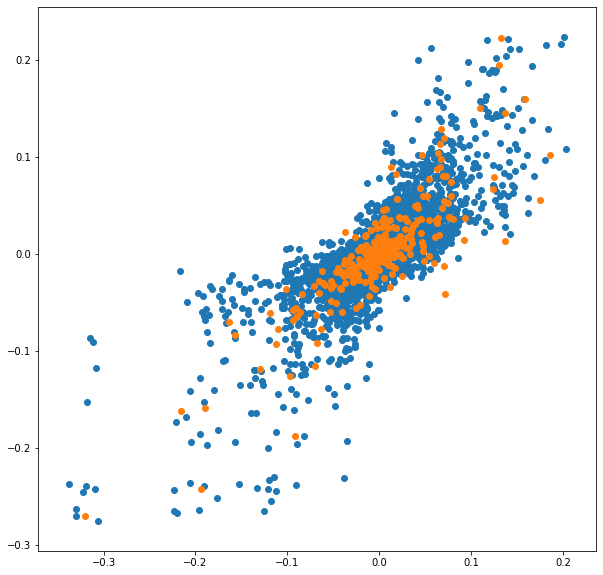

In [295]:
s1 = C1.sample(len(rs)*10)
s2 = C2.sample(len(rf)*10)
plt.figure(figsize=(10,10))
plt.scatter(s1[:,0], s1[:,1])
# plt.scatter(s2[:,0], s2[:,1])
# plt.scatter(rs_test,rf_test)
plt.scatter(rs,rf)

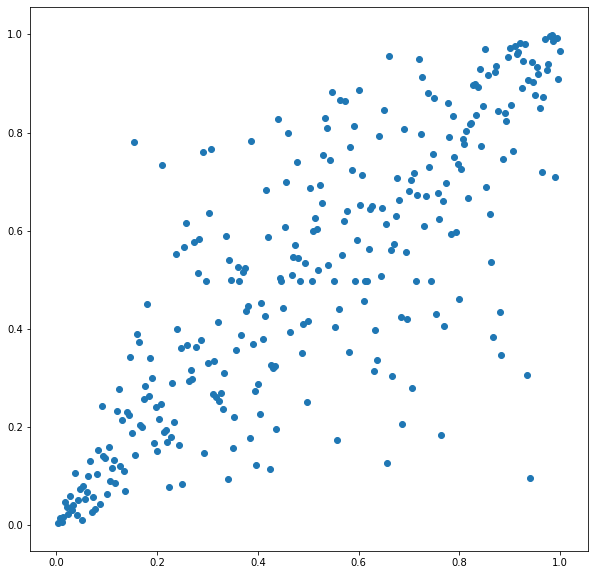

In [296]:
u1s = ECDF(s1[:,0])(s1[:,0])
u1f = ECDF(s1[:,1])(s1[:,1])

u2s = ECDF(s2[:,0])(s2[:,0])
u2f = ECDF(s2[:,1])(s2[:,1])

plt.figure(figsize=(10,10))
# plt.scatter(u1s, u1f)
# plt.scatter(u2s, u2f)
plt.scatter(u,v)

0.9206706706706707


Text(0.5, 0, 'h')

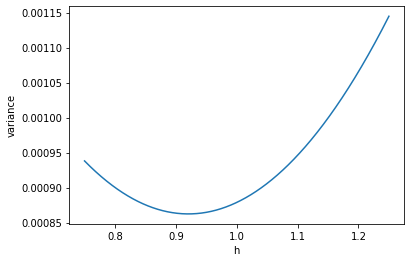

In [260]:
h_arr = np.linspace(0.75,1.25,1000)

var_arr = []
for h in h_arr:
    rh = rs - h*rf
    var_arr.append(np.var(rh))
plt.plot(h_arr, var_arr)
print(h_arr[np.argmin(var_arr)])
plt.ylabel('variance')
plt.xlabel('h')

In [261]:
e_h = h_arr[np.argmin(var_arr)]

In [262]:
var_1 = np.var(rs_test - e_h*rf_test)
var_2 = np.var(rs_test - h2_arr[0]*rf_test)
var_rs = np.var(rs_test)

HE_var_1 = 1-var_1/var_rs 
HE_var_2 = 1-var_2/var_rs 
print(HE_var_1, HE_var_2)

0.5276316138901116 0.52235966412464


0.9206706706706707


Text(0.5, 1.0, 'Variance of rh, in-sample')

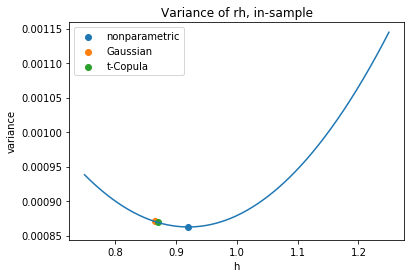

In [263]:
plt.plot(h_arr, var_arr)
print(h_arr[np.argmin(var_arr)])
plt.ylabel('variance')
plt.xlabel('h')

plt.scatter([e_h], [np.var(rs-e_h*rf)], label='nonparametric')
plt.scatter([h1_arr[0]], [np.var(rs-h1_arr[0]*rf)], label='Gaussian')
plt.scatter([h2_arr[0]], [np.var(rs-h2_arr[0]*rf)], label='t-Copula')
plt.legend()
plt.title('Variance of rh, in-sample')

0.9922422422422422


Text(0.5, 1.0, 'Variance of rh, out-of-sample')

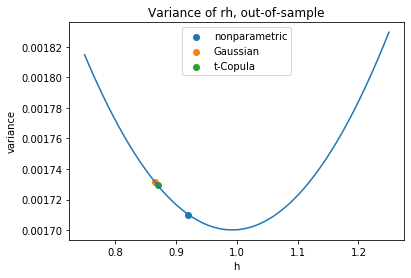

In [264]:
var_arr = []
for h in h_arr:
    rh = rs_test - h*rf_test
    var_arr.append(np.var(rh))

plt.plot(h_arr, var_arr)
print(h_arr[np.argmin(var_arr)])
plt.ylabel('variance')
plt.xlabel('h')

plt.scatter([e_h], [np.var(rs_test-e_h*rf_test)], label='nonparametric')
plt.scatter([h1_arr[0]], [np.var(rs_test-h1_arr[0]*rf_test)], label='Gaussian')
plt.scatter([h2_arr[0]], [np.var(rs_test-h2_arr[0]*rf_test)], label='t-Copula')
plt.legend()
plt.title('Variance of rh, out-of-sample')

0.8841341341341341


Text(0.5, 0, 'h')

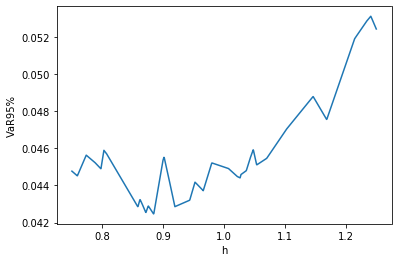

In [265]:
# h_arr = np.linspace(0,1,1000)

VaR95_arr = []
for h in h_arr:
    rh = rs - h*rf
    VaR95_arr.append(-np.quantile(rh, 0.05))
plt.plot(h_arr, VaR95_arr)

e_h = h_arr[np.argmin(VaR95_arr)]

print(h_arr[np.argmin(VaR95_arr)])
plt.ylabel('VaR95%')
plt.xlabel('h')

In [266]:
VaR95_1 = np.quantile(rs_test - e_h*rf_test, 0.05)
VaR95_2 = np.quantile(rs_test - h2_arr[5]*rf_test, 0.05)
VaR95_rs = np.quantile(rs_test, 0.05)

HE_VaR95_1 = 1-VaR95_1/VaR95_rs 
HE_VaR95_2 = 1-VaR95_2/VaR95_rs

print(HE_VaR95_1, HE_VaR95_2)

0.4304037993456977 0.4146168750159319


Text(0.5, 1.0, 'VaR95% of rh, out-of-sample')

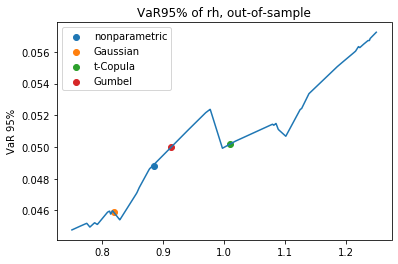

In [267]:
VaR95_arr = []
for h in h_arr:
    rh = rs_test - h*rf_test
    VaR95_arr.append(-np.quantile(rh, 0.05))
plt.plot(h_arr, VaR95_arr)

plt.scatter([e_h], [-np.quantile(rs_test-e_h*rf_test, 0.05)], label='nonparametric')
plt.scatter([h1_arr[5]], [-np.quantile(rs_test-h1_arr[5]*rf_test, 0.05)], label='Gaussian')
plt.scatter([h2_arr[5]], [-np.quantile(rs_test-h2_arr[5]*rf_test, 0.05)], label='t-Copula')
plt.scatter([h3_arr[5]], [-np.quantile(rs_test-h3_arr[5]*rf_test, 0.05)], label='Gumbel')

plt.legend()
plt.ylabel('VaR 95%')
plt.title('VaR95% of rh, out-of-sample')

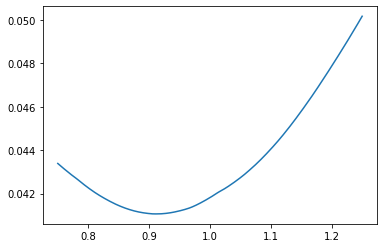

In [268]:
ERM_arr = []
for h in h_arr:
    rh = rs - h*rf
    risk = ERM_estimate_trapezoidal(10, rh)
    ERM_arr.append(risk)
    
plt.plot(h_arr, ERM_arr)

In [269]:
e_h = h_arr[np.argmin(ERM_arr)]
e_h

0.9106606606606606

Text(0.5, 1.0, 'ERM of rh, out-of-sample')

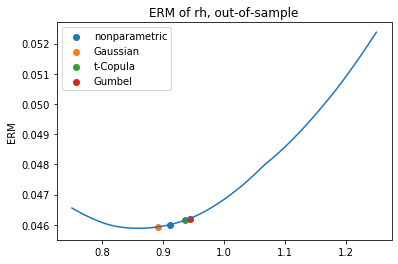

In [270]:
ERM_arr = []
for h in h_arr:
    rh = rs_test - h*rf_test
    risk = ERM_estimate_trapezoidal(10, rh)
    ERM_arr.append(risk)
    
plt.plot(h_arr, ERM_arr)

plt.scatter([e_h], [ERM_estimate_trapezoidal(10,rs_test-e_h*rf_test)], label='nonparametric')
plt.scatter([h1_arr[1]], [ERM_estimate_trapezoidal(10,rs_test-h1_arr[1]*rf_test)], label='Gaussian')
plt.scatter([h2_arr[1]], [ERM_estimate_trapezoidal(10, rs_test-h2_arr[1]*rf_test)], label='t-Copula')
plt.scatter([h3_arr[1]], [ERM_estimate_trapezoidal(10,rs_test-h3_arr[1]*rf_test)], label='Gumbel')

plt.legend()
plt.ylabel('ERM')
plt.title('ERM of rh, out-of-sample')